In [37]:
import pandas as pd
import numpy as np
from bayes_approach import Bayesian_AB
import numpy as np
import arviz as az
from dotenv import load_dotenv

load_dotenv()

True

In [38]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

In [39]:
query = '''
with precondition as (
    SELECT
    	DISTINCT(s.session_id) as session_id
    FROM
    	HEYCAR.MARKETING m
    JOIN
        HEYCAR.SESSION s on m.CAMPAIGN_NAME = s.MKT_CAMPAIGN_NAME
    WHERE
    	m.CAMPAIGN_NAME in ('DE_PS_PRO_CLS_CATALOGS_DYNAMIC_TEST_HOTNESS_NEW_1SEP','DE_PS_PRO_CLS_CATALOGS_DYNAMIC_TEST_CONTROL_NEW_1SEP')
        AND s.session_day between '2022-09-10' and '2022-10-20'
        --AND s.platform_id = 0
        --AND s.device_type in ('desktop', 'tablet')
        AND (s.is_bot is null OR s.is_bot = 0)
        --AND s.has_tracking_consent = 1
        AND s.country_code = 'de'      
), sessions as (
	SELECT
		s.session_id,
		s.session_day,
		s.MKT_CAMPAIGN_NAME as test_group
    FROM
        HEYCAR.SESSION s
    WHERE
    	s.session_day between '2022-09-14' and '2022-10-14'
        --AND s.device_type in ('desktop', 'tablet')
        AND (s.is_bot is null OR s.is_bot = 0)
        --AND s.has_tracking_consent = 1
        AND s.country_code = 'de'
        AND s.session_id in (SELECT session_id FROM precondition)
    GROUP BY
    	1, 2, 3
), 
listings as (
    -- all listings that were availale in testing timeframe
    select
        ls.listing_id,
        l.created_day
    from
        HEYCAR.LISTING_SNAPSHOT ls
    left join HEYCAR.LISTING l ON ls.listing_id = l.listing_id
    where
        ls.country_code ='de'
        AND ls.is_live = 1
        and SNAPSHOT_DAY between '2022-09-14' and '2022-10-14'
),
non_leads as (
    -- find all lifetime leads from those listings above
    select
        listing_id,
        lead_id,
        created_day,
        created_at,
        (case when ONE_CLICK_PARENT_LEAD_ID is not null then 1 else 0 end) as oc_lead,
        row_number() over (PARTITION BY listing_id ORDER BY created_at ASC) as order_of_lead
    from
        heycar.lead
    where
        country_code='de'
        --AND created_day between '2022-09-14' and '2022-10-14'
        AND listing_id IN (select distinct listing_id from listings)
),
leads as (
	SELECT
		sl.session_id,
		sl.session_day,
		(case when count(distinct l.lead_id)> 0 then 1 else 0 end) as leads
	FROM
		HEYCAR.SESSION_LEAD_LOOKUP sl
    JOIN
        HEYCAR.LEAD l on sl.lead_id = l.lead_id
	WHERE
        sl.session_day between '2022-09-10' and '2022-10-20'
        AND sl.country_code = 'de' 
        AND l.IS_QUALITY_LEAD = 1
        AND l.lead_id NOT IN (SELECT distinct lead_id FROM non_leads WHERE order_of_lead >8)
    GROUP BY
        1, 2

)

SELECT
    s.session_id,
	s.session_day,
	s.test_group,
	nvl(l.leads, 0) as leads
FROM
	sessions s
LEFT JOIN
	leads l on s.session_id = l.session_id
'''

In [40]:
E = Bayesian_AB(project_name='Listing_score_phase_1_stat_result')

In [41]:
df = E.get_data(load_new=True, query=query)
df

/Users/datnguyen/opt/anaconda3/lib/python3.8/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,session_id,session_day,test_group,leads
0,ajs-2407175286594408e046e26bb07e4b79,2022-09-29,DE_PS_PRO_CLS_CATALOGS_DYNAMIC_TEST_HOTNESS_NE...,1
1,ajs-ed5ff977c486281b0762eef44cd20078,2022-09-17,DE_PS_PRO_CLS_CATALOGS_DYNAMIC_TEST_CONTROL_NE...,1
2,ajs-9a628f19472417b0f2d3d1a183c7d015,2022-10-05,DE_PS_PRO_CLS_CATALOGS_DYNAMIC_TEST_CONTROL_NE...,1
3,ajs-c7d17bd46ad0ce847a2a656e85b1ce03,2022-10-02,DE_PS_PRO_CLS_CATALOGS_DYNAMIC_TEST_CONTROL_NE...,1
4,eb755299008ce11b1fa3e47f926e3bb8,2022-09-15,DE_PS_PRO_CLS_CATALOGS_DYNAMIC_TEST_HOTNESS_NE...,1
...,...,...,...,...
249408,ajs-2d6f8bf1bc2774a535614b002ec76d99,2022-10-14,DE_PS_PRO_CLS_CATALOGS_DYNAMIC_TEST_CONTROL_NE...,0
249409,ajs-0e587a454a3b38604cb15028bc58af64,2022-09-27,DE_PS_PRO_CLS_CATALOGS_DYNAMIC_TEST_HOTNESS_NE...,0
249410,ajs-7a29791d84aca49af96c939438b74464,2022-10-07,DE_PS_PRO_CLS_CATALOGS_DYNAMIC_TEST_CONTROL_NE...,0
249411,ajs-cca62de4b5439159b97da4fac02f636f,2022-09-28,DE_PS_PRO_CLS_CATALOGS_DYNAMIC_TEST_CONTROL_NE...,0


In [42]:
c, v = E.prepare_data(df,
                      control_filter='DE_PS_PRO_CLS_CATALOGS_DYNAMIC_TEST_CONTROL_NEW_1SEP',
                      variant_filter='DE_PS_PRO_CLS_CATALOGS_DYNAMIC_TEST_HOTNESS_NEW_1SEP',
                      date_column='session_day',
                      sample_column='session_id',
                      conversion_column='leads',
                      test_column='test_group',
                      day_index=True
                     ) 
#control group & variant group

In [43]:
c #control (desktop)

,DATE,WEEK_DAY,session_id,leads
DAY,,,,
0,2022-09-14,Wednesday,3582,4
1,2022-09-15,Thursday,3330,8
2,2022-09-16,Friday,3786,6
3,2022-09-17,Saturday,3838,8
4,2022-09-18,Sunday,4104,3
5,2022-09-19,Monday,3477,4
6,2022-09-20,Tuesday,3408,4
7,2022-09-21,Wednesday,3507,7
8,2022-09-22,Thursday,3439,4


In [44]:
v #variant (desktop)

,DATE,WEEK_DAY,session_id,leads
DAY,,,,
0,2022-09-14,Wednesday,4793,10
1,2022-09-15,Thursday,4319,9
2,2022-09-16,Friday,4193,10
3,2022-09-17,Saturday,4788,5
4,2022-09-18,Sunday,4692,5
5,2022-09-19,Monday,4601,7
6,2022-09-20,Tuesday,4730,5
7,2022-09-21,Wednesday,4736,1
8,2022-09-22,Thursday,4745,6


In [45]:
simulation_ImSa = E.posterior_analytic_importance_sampling(control=c,
                                                           variant=v)

/Users/datnguyen/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/datnguyen/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/datnguyen/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/datnguyen/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/datnguyen/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/datnguyen/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_di

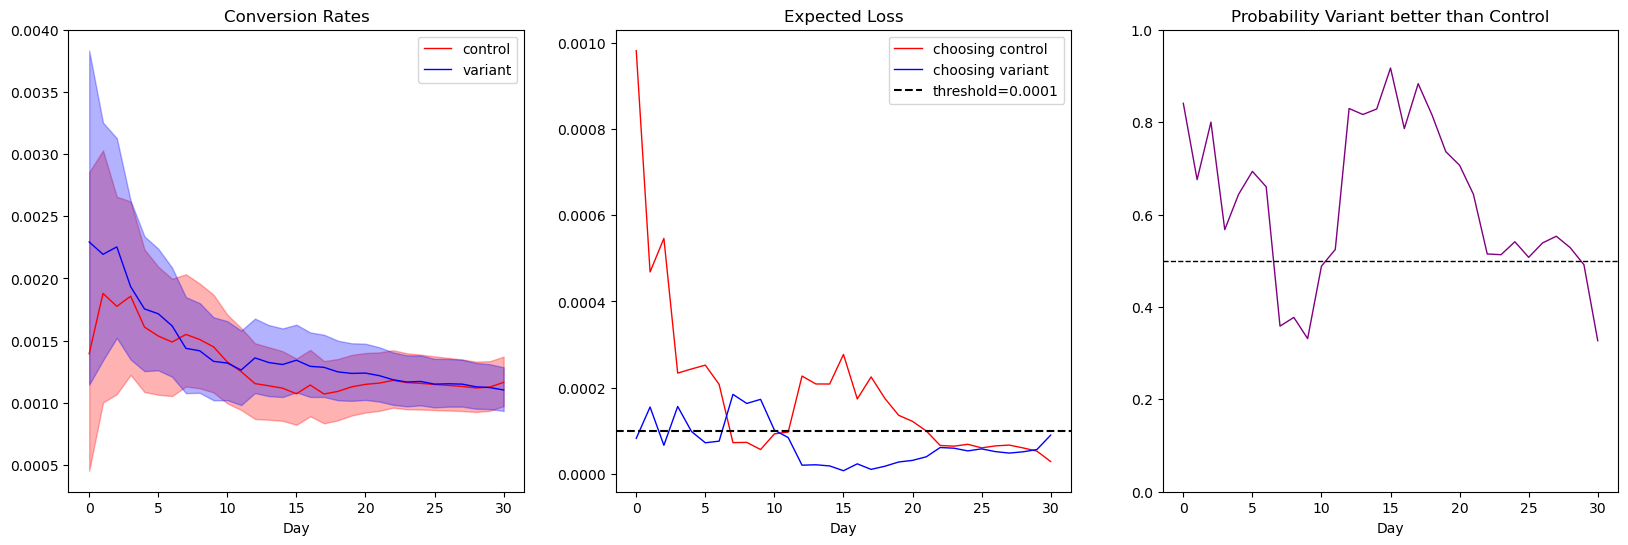

In [46]:
E.plot_expected_loss(simulation_ImSa)

In [47]:
E.get_results()

VALUE
GROUP   METRIC                                       
control CvR                                   0.00116
        sample size                            112521
        conversions                               130
        95% credible interval      (0.00097, 0.00137)
variant CvR                                   0.00110
        sample size                            136891
        conversions                               150
        95% credible interval      (0.00093, 0.00129)
outcome uplift                                -5.253%
        control expected loss                0.000029
        variant expected loss                 0.00009
        prob (variant >= control)             32.689%
        standard error                       0.000696

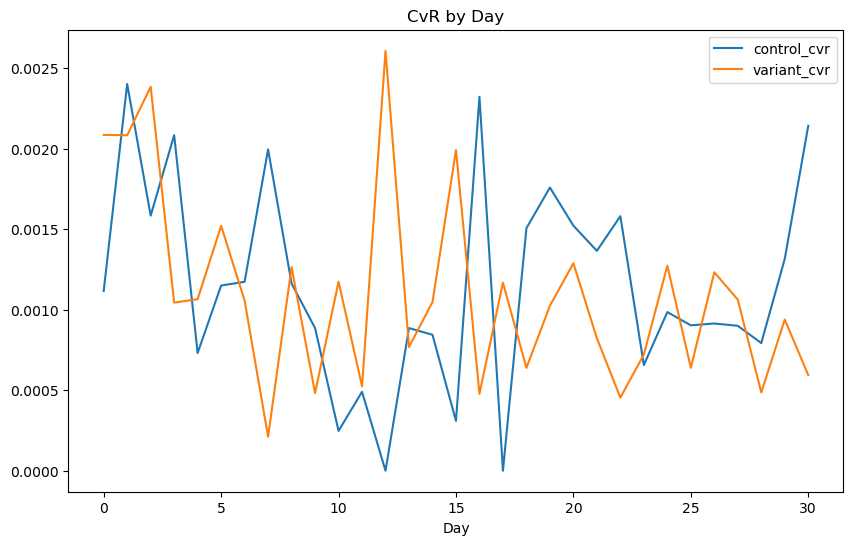

In [48]:
E.plot_lines(c, v)